In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

In [2]:
# def rgb2gray(rgb):
#     r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
#     return gray

def fractal_dimension(Z, threshold=50):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

In [75]:
A1 = [cv2.cvtColor(cv2.imread('A1-1.PNG'), cv2.COLOR_BGR2GRAY), 
      cv2.cvtColor(cv2.imread('A1-2.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('A1-3.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('A1-4.PNG'), cv2.COLOR_BGR2GRAY)]

A2 = [
#       cv2.cvtColor(cv2.imread('A2-1.png'), cv2.COLOR_BGR2GRAY), 
      cv2.cvtColor(cv2.imread('A2-2.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('A2-3.PNG'), cv2.COLOR_BGR2GRAY)]

B1 = [cv2.cvtColor(cv2.imread('B1-1.PNG'), cv2.COLOR_BGR2GRAY), 
      cv2.cvtColor(cv2.imread('B1-2.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('B1-3.PNG'), cv2.COLOR_BGR2GRAY)]

B2 = [cv2.cvtColor(cv2.imread('B2-0.PNG'), cv2.COLOR_BGR2GRAY), 
      cv2.cvtColor(cv2.imread('B2-1.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('B2-2.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('B2-3.PNG'), cv2.COLOR_BGR2GRAY),
#       rgb2gray(imageio.imread('B2-4.PNG'))
     ]

C1 = [cv2.cvtColor(cv2.imread('C1-1.PNG'), cv2.COLOR_BGR2GRAY), 
      cv2.cvtColor(cv2.imread('C1-2.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('C1-3.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('C1-4.PNG'), cv2.COLOR_BGR2GRAY)]

D1 = [cv2.cvtColor(cv2.imread('D1-1.PNG'), cv2.COLOR_BGR2GRAY), 
      cv2.cvtColor(cv2.imread('D1-2.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('D1-3.PNG'), cv2.COLOR_BGR2GRAY),
      cv2.cvtColor(cv2.imread('D1-4.PNG'), cv2.COLOR_BGR2GRAY)]

In [18]:
x_names = ["A1", "A2", "B1", "B2", "C1", "D1"]

In [165]:
cnts = find_contour(cv2.cvtColor(cv2.imread('A1-1.PNG'), cv2.COLOR_BGR2GRAY))
mvp = grahamscan(cnts)
square_polygon(mvp)

6858

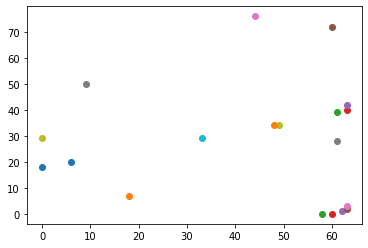

In [186]:
x = []
y = []
for v in mvp:
  x.append(v[0])
  y.append(v[1])
labels = np.arange(len(x)) 
fig, ax = plt.subplots(nrows=1, ncols=1)
for x_,y_,label in zip(x,y,labels):
    ax.scatter([x_], [y_], label=label, picker=3)

In [166]:
x,y = cv2.cvtColor(cv2.imread('A1-1.PNG'), cv2.COLOR_BGR2GRAY).shape
x*y

4928

# Площадь минимальной выпуклой оболочки - МВО (minimal convex hull - MCH)

In [46]:
def find_contour(gray):
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    thresh = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY_INV)[1]
    # Find contours
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    #c = max(cnts, key=cv2.contourArea) ?
    cnts = np.asarray(cnts)
    cnts = cnts.reshape(-1,2)
    return cnts

In [76]:
def rotate(A,B,C):
    return (B[0]-A[0])*(C[1]-B[1])-(B[1]-A[1])*(C[0]-B[0])

def grahamscan(A):
    n = len(A) # число точек
    P = list(range(n)) # список номеров точек
    for i in range(1,n):
        if A[P[i]][0]<A[P[0]][0]: # если P[i]-ая точка лежит левее P[0]-ой точки
            P[i], P[0] = P[0], P[i] # меняем местами номера этих точек 
    for i in range(2,n):
        j = i
        while j>1 and (rotate(A[P[0]],A[P[j-1]],A[P[j]])<0): 
            P[j], P[j-1] = P[j-1], P[j]
            j -= 1
    S = [P[0],P[1]]
    for i in range(2,n):
        while rotate(A[S[-2]],A[S[-1]],A[P[i]])<0:
            del S[-1] # pop(S)
        S.append(P[i]) # push(S,P[i])
    return [A[i] for i in S]

In [77]:
def square_polygon(points):
    n = len(points)
    sum = points[n-1][0] * points[0][1] - points[n-1][1] * points[0][0]
    for i in range(0, n-1):
        sum = sum + (points[i][0] * points[i + 1][1] - points[i][1] * points[i + 1][0])
    return sum

In [78]:
def mch(Cat):
    cat = []
    for c in Cat:
        cnts = find_contour(c)
        mvp = grahamscan(cnts)
        cat.append(square_polygon(mvp))
    return cat

In [79]:
a1_mch = mch(A1)
a2_mch = mch(A2)
b1_mch = mch(B1)
b2_mch = mch(B2)
c1_mch = mch(C1)
d1_mch = mch(D1)

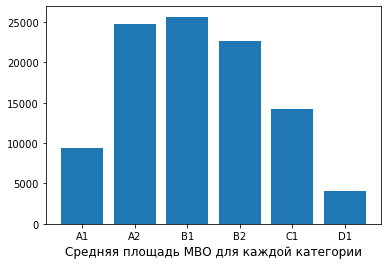

In [80]:
y_mch = [np.mean(a1_mch),np.mean(a2_mch), np.mean(b1_mch), np.mean(b2_mch), np.mean(c1_mch), np.mean(d1_mch)]

plt.bar(x_names, y_mch)
 
# Custom Axis title
plt.xlabel('Средняя площадь МВО для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

# Количество черных пикселей

In [82]:
def black(Cat):
    cat = []
    for c in Cat:
        cat.append(cv2.countNonZero(c))
    return cat

In [83]:
a1_black = black(A1)
a2_black = black(A2)
b1_black = black(B1)
b2_black = black(B2)
c1_black = black(C1)
d1_black = black(D1)

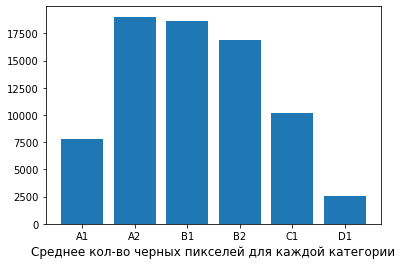

In [84]:
y_black = [np.mean(a1_black),np.mean(a2_black), np.mean(b1_black), np.mean(b2_black), np.mean(c1_black), np.mean(d1_black)]

plt.bar(x_names, y_black)
 
# Custom Axis title
plt.xlabel('Среднее кол-во черных пикселей для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

In [163]:
data = pd.DataFrame([], columns=["Отношение", "ЧП"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        data = data.append({"ЧП": cv2.countNonZero(c),"Тип": key}, ignore_index=True)

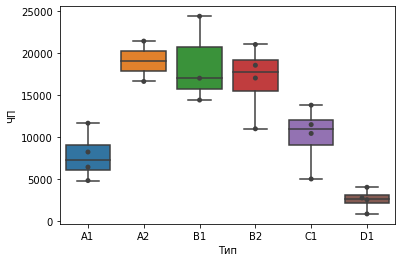

In [164]:
ax = sns.boxplot(x="Тип", y="ЧП", data=data)
ax = sns.swarmplot(x="Тип", y="ЧП", data=data, color=".25")

# Количество белых пикселей

In [179]:
def white(Cat):
    cat = []
    for c in Cat:
        cnts = find_contour(c)
        mvp = grahamscan(cnts)
        mch = square_polygon(mvp)
        cat.append(mch - cv2.countNonZero(c))
    return cat

In [180]:
a1_white = white(A1)
a2_white = white(A2)
b1_white = white(B1)
b2_white = white(B2)
c1_white = white(C1)
d1_white = white(D1)

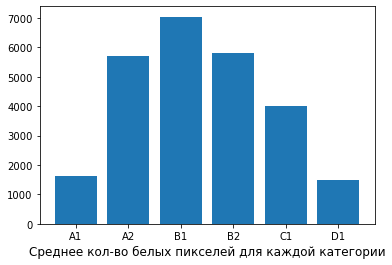

In [181]:
y_white = [np.mean(a1_white),np.mean(a2_white), np.mean(b1_white), np.mean(b2_white), np.mean(c1_white), np.mean(d1_white)]

plt.bar(x_names, y_white)
 
# Custom Axis title
plt.xlabel('Среднее кол-во белых пикселей для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

In [182]:
data = pd.DataFrame([], columns=["БП", "Тип"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        x, y = c.shape
        TotalNumberOfPixels = x * y
        white = TotalNumberOfPixels - cv2.countNonZero(c)
        data = data.append({"БП": white,"Тип": key}, ignore_index=True)

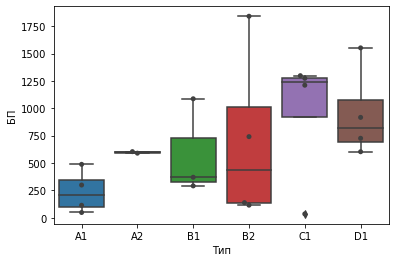

In [183]:
ax = sns.boxplot(x="Тип", y="БП", data=data)
ax = sns.swarmplot(x="Тип", y="БП", data=data, color=".25")

# Отношение черных к белым

In [187]:
def relate(black, white):
    return [b / white[n] for n, b in enumerate(black)]

In [188]:
a1_relate = relate(a1_black, a1_white)
a2_relate = relate(a2_black, a2_white)
b1_relate = relate(b1_black, b1_white)
b2_relate = relate(b2_black, b2_white)
c1_relate = relate(c1_black, c1_white)
d1_relate = relate(d1_black, d1_white)

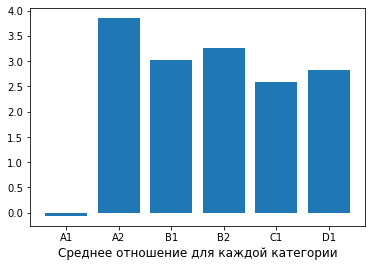

In [189]:
y_relate = [np.mean(a1_relate),np.mean(a2_relate), np.mean(b1_relate), np.mean(b2_relate), np.mean(c1_relate), np.mean(d1_relate)]

plt.bar(x_names, y_relate)
 
# Custom Axis title
plt.xlabel('Среднее отношение для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

In [190]:
data = pd.DataFrame([], columns=["Отношение", "Тип"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        x, y = c.shape
        TotalNumberOfPixels = x * y
        white = TotalNumberOfPixels - cv2.countNonZero(c)
        data = data.append({"Отношение": cv2.countNonZero(c)/white,"Тип": key}, ignore_index=True)

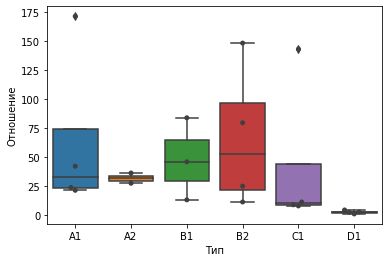

In [191]:
ax = sns.boxplot(x="Тип", y="Отношение", data=data)
ax = sns.swarmplot(x="Тип", y="Отношение", data=data, color=".25")

# Фрактальный размер

In [98]:
def fract(Cat):
    cat = []
    for c in Cat:
        cat.append(fractal_dimension(c))
    return cat

In [99]:
a1_fract = fract(A1)
a2_fract = fract(A2)
b1_fract = fract(B1)
b2_fract = fract(B2)
c1_fract = fract(C1)
d1_fract = fract(D1)

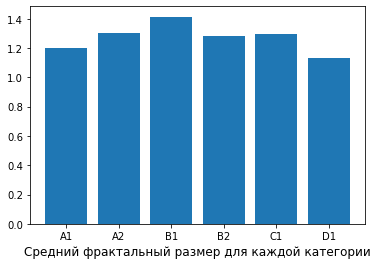

In [100]:
y_frac = [np.mean(a1_fract),np.mean(a2_fract), np.mean(b1_fract), np.mean(b2_fract), np.mean(c1_fract), np.mean(d1_fract)]

plt.bar(x_names, y_frac)
 
# Custom Axis title
plt.xlabel('Средний фрактальный размер для каждой категории', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

# Площадь

In [102]:
def square(Cat):
    cat = []
    for c in Cat:
        x,y = c.shape
        cat.append(x*y)
    return cat

In [103]:
sqr_a1 = square(A1)
sqr_a2 = square(A2)
sqr_b1 = square(B1)
sqr_b2 = square(B2)
sqr_c1 = square(C1)
sqr_d1 = square(D1)

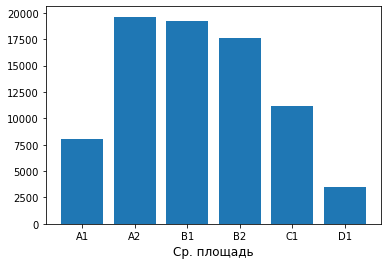

In [104]:
y_square = [np.mean(sqr_a1),np.mean(sqr_a2),np.mean(sqr_b1),np.mean(sqr_b2),np.mean(sqr_c1),np.mean(sqr_d1)]

plt.bar(x_names, y_square)
 
# Custom Axis title
plt.xlabel('Ср. площадь', fontsize='12', horizontalalignment='center')

# Show the graph
plt.show()

Кластеризация

In [192]:
df = pd.DataFrame([], columns=["Площадь", "Площадь МВО", "Фрактал","ЧП", "БП", "Отношение"], index = x_names)
df["Площадь"] = y_square
df['Площадь МВО'] = y_mch
df['Фрактал'] = y_frac
df['Отношение'] = y_relate
df['ЧП'] = y_black
df['БП'] = y_white
df

,Площадь,Площадь МВО,Фрактал,ЧП,БП,Отношение
A1,8015.000000,9413.750000,1.203143,7777.75,1636.000000,-0.065456
A2,19634.000000,24732.500000,1.305202,19037.00,5695.500000,3.846956
B1,19194.666667,25660.333333,1.413779,18612.00,7048.333333,3.011882
B2,17615.250000,22700.000000,1.284579,16906.50,5793.500000,3.249697
C1,11136.250000,14194.250000,1.295335,10181.75,4012.500000,2.589654
D1,3479.750000,4030.250000,1.134932,2530.25,1500.000000,2.825974


In [135]:
def knn_comparison(data,cat,i,clf):
    x = data.values.astype('int')
    y = pd.Categorical(cat).codes
    clf.fit(x, y)
    # Plotting decision region
    plot_decision_regions(x, y, clf=clf, legend=2)
    # Adding axes annotations
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Score of '+i+':'+ str(clf.score(x,y)))
    plt.show()

In [136]:
def knn_comparison2(x,cat,i,clf):
    y = pd.Categorical(cat).codes
    clf.fit(x, y)
    plt.scatter(x.iloc[:, [0]],x.iloc[:, [1]], c=clf.predict(x))
    plt.title('Score of '+i+':'+ str(clf.score(x,y)))
    plt.show()

In [202]:
data = pd.DataFrame([], columns=['Площадь МВО',"Фрактал", "ЧП", "БП", "Тип"])
cats = {"A1":A1,"A2":A2,"B1":B1,"B2":B2,"C1":C1,"D1":D1}
for key, cat in cats.items():
    for c in cat:
        cnts = find_contour(c)
        mvp = grahamscan(cnts)
        mch = square_polygon(mvp)
        white = mch - cv2.countNonZero(c)
        data = data.append({'Площадь МВО': mch,
                            "Фрактал": fractal_dimension(c), 
                            "ЧП": cv2.countNonZero(c), 
                            "БП": white,
                            "Тип": key}, ignore_index=True)

In [203]:
data.drop(["Тип"], axis=1).head()

,Площадь МВО,Фрактал,ЧП,БП
0,6858,1.363760,4814,2044
1,9035,1.086960,8220,815
2,6008,1.101667,6421,-413
3,15754,1.260184,11656,4098
4,24101,1.294424,16632,7469


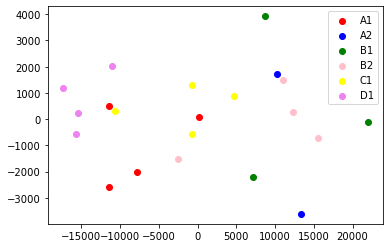

In [204]:
from sklearn.manifold import TSNE

# Определяем модель и скорость обучения
model = TSNE(n_components=2, learning_rate=1, init='pca')

# Обучаем модель
transformed = model.fit_transform(data.drop(["Тип"], axis=1))

# Представляем результат в двумерных координатах
x_axis = transformed[:, 0]
y_axis = transformed[:, 1]
group = data["Тип"]
cdict = {"A1": 'red', "A2": 'blue', "B1": 'green', "B2":'pink', "C1":'yellow', "D1":'violet'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(x_axis[ix], y_axis[ix], c = cdict[g], label = g)
ax.legend()
plt.show()

In [205]:
from sklearn.neighbors import KNeighborsClassifier

lr = LogisticRegression(random_state=1,
                      solver='newton-cg',
                      multi_class='multinomial')
rf = RandomForestClassifier(random_state=1, n_estimators=100)
gaus = GaussianNB()
neig = KNeighborsClassifier(n_neighbors=6)
algs = {
    "LogisticRegression":lr,
    "RandomForest":rf,
    "Gausian": gaus,
    "KNeighbors":neig
}

In [206]:
for i, clf in algs.items():
    clf.fit(data.drop(["Тип"],axis=1), data["Тип"])
    print("score of "+i+" is "+str(clf.score(data.drop(["Тип"],axis=1), data["Тип"])))

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


score of LogisticRegression is 0.6666666666666666
score of RandomForest is 1.0
score of Gausian is 0.6190476190476191
score of KNeighbors is 0.6666666666666666


# Отношение отношения ЧП к БП и фрактальной размерности

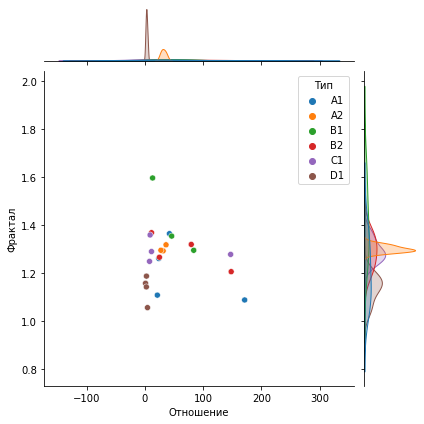

In [ ]:
sns.jointplot(data=data, x="Отношение", y="Фрактал", hue="Тип")

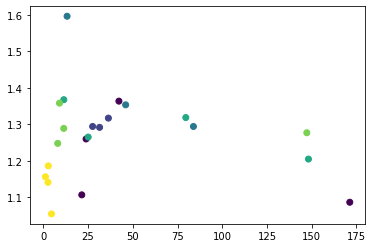

In [ ]:
plt.scatter(data["Отношение"],data['Фрактал'], c=pd.Categorical(data["Тип"]).codes)
plt.show()

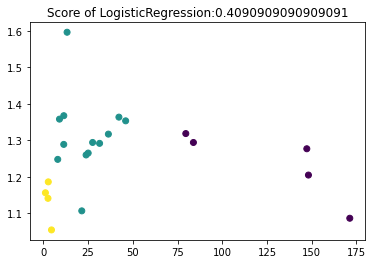

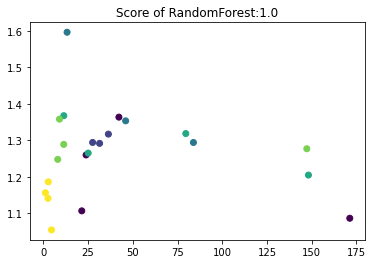

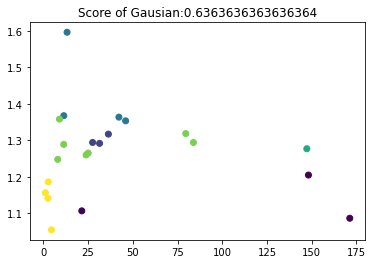

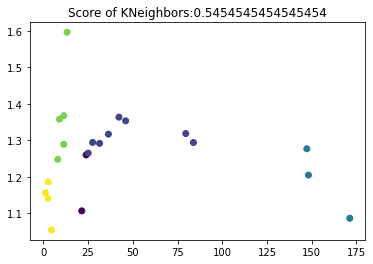

In [ ]:
for i, clf in algs.items():
    knn_comparison2(data[["Отношение","Фрактал"]], data["Тип"],i, clf)

# Отношение площади прямоугольника и фрактальной размерности

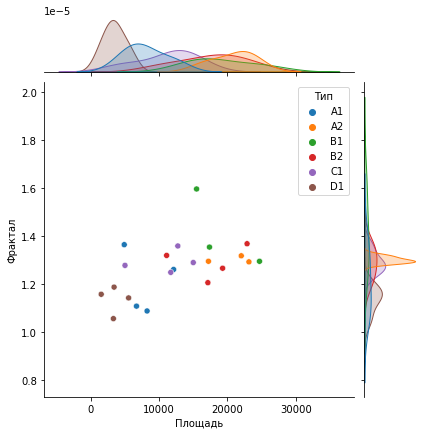

In [ ]:
sns.jointplot(data=data, x="Площадь", y="Фрактал", hue="Тип")

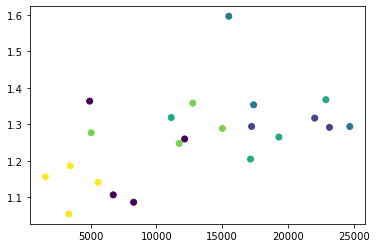

In [ ]:
plt.scatter(data["Площадь"],data['Фрактал'], c=pd.Categorical(data["Тип"]).codes)
plt.show()

/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


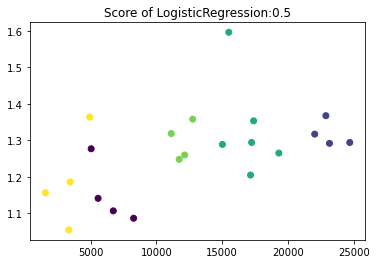

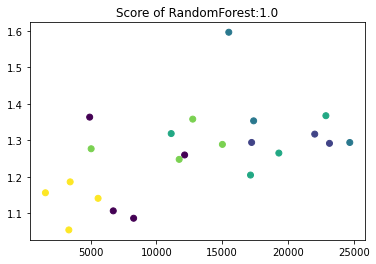

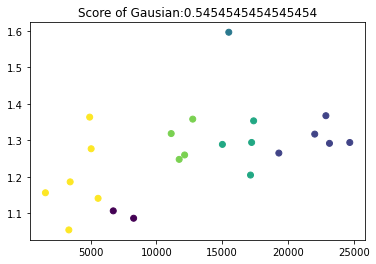

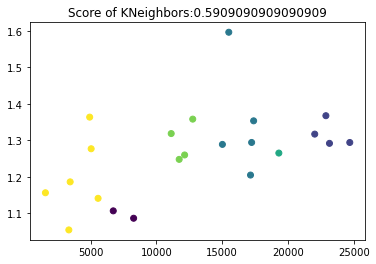

In [ ]:
for i, clf in algs.items():
    knn_comparison2(data[["Площадь","Фрактал"]], data["Тип"],i, clf)

# Отношение площади и отношения чп к бп

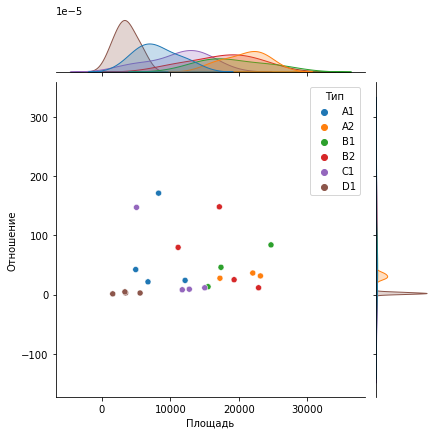

In [ ]:
sns.jointplot(data=data, x="Площадь", y="Отношение", hue="Тип")

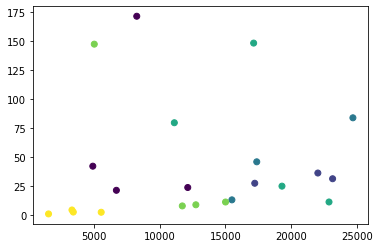

In [ ]:
plt.scatter(data["Площадь"],data['Отношение'], c=pd.Categorical(data["Тип"]).codes)
plt.show()

/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


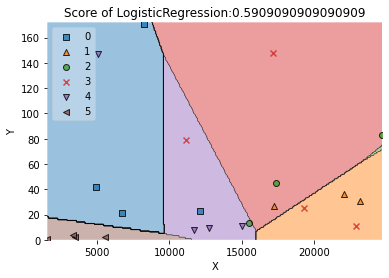

/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


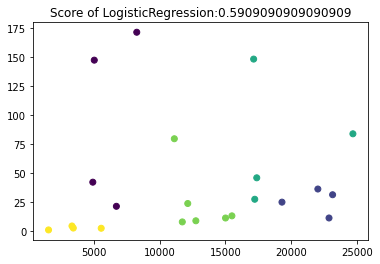

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


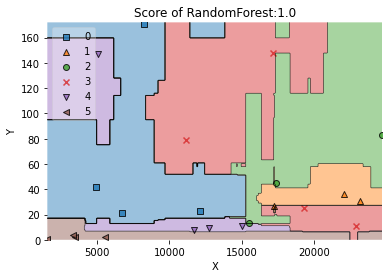

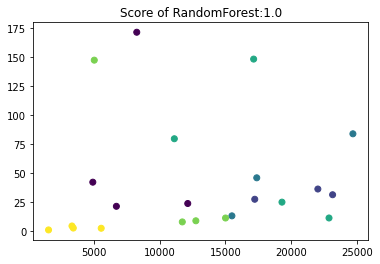

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


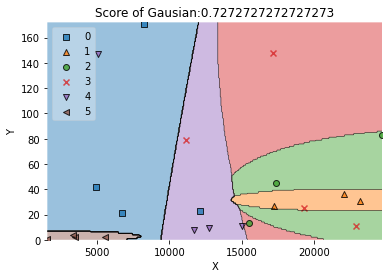

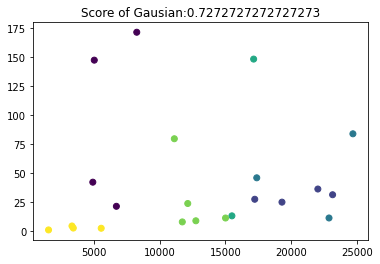

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


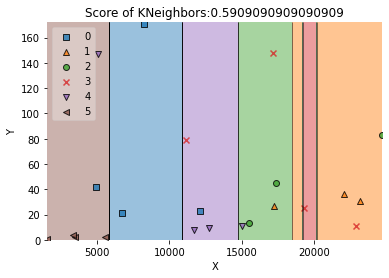

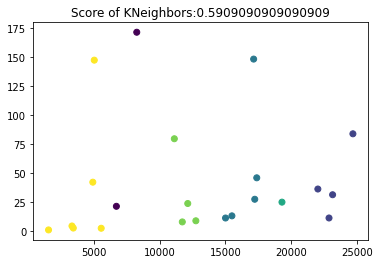

In [ ]:
for i, clf in algs.items():
    knn_comparison(data[["Площадь","Отношение"]], data["Тип"],i, clf)
    knn_comparison2(data[["Площадь","Отношение"]], data["Тип"],i, clf)

# Отношение чп и отношения чп к бп

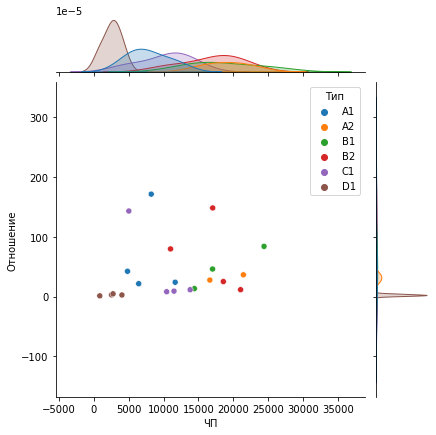

In [150]:
sns.jointplot(data=data, x="ЧП", y="Отношение", hue="Тип")

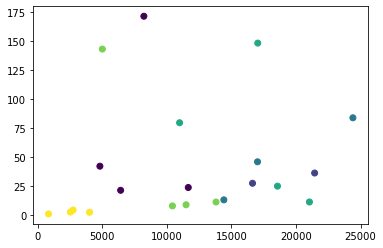

In [151]:
plt.scatter(data["ЧП"],data['Отношение'], c=pd.Categorical(data["Тип"]).codes)
plt.show()

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


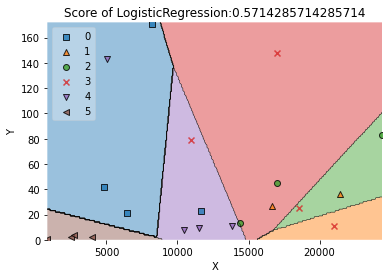

/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


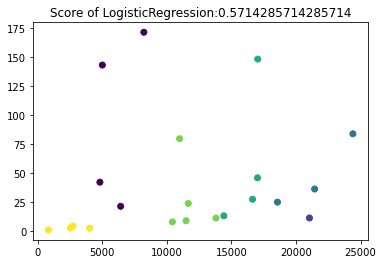

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


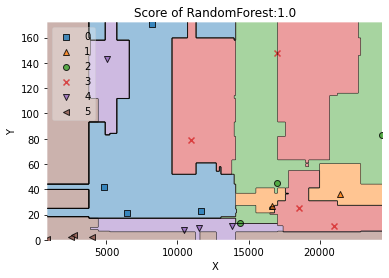

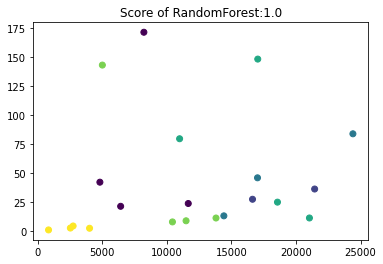

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


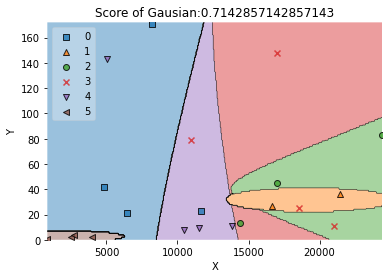

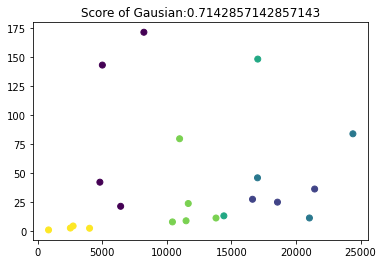

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


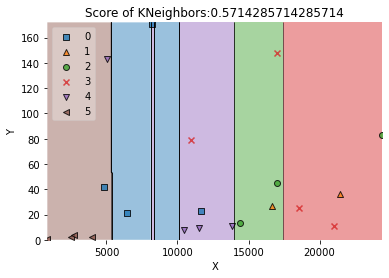

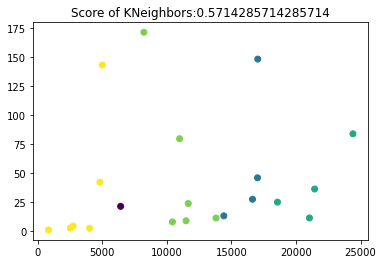

In [152]:
for i, clf in algs.items():
    knn_comparison(data[["ЧП", "Отношение"]], data["Тип"],i, clf)
    knn_comparison2(data[["ЧП", "Отношение"]], data["Тип"],i, clf)    

# Отношение бп к отношению чп к бп

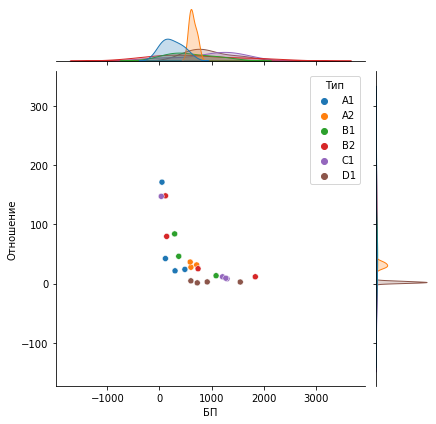

In [ ]:
sns.jointplot(data=data, x="БП", y="Отношение", hue="Тип")

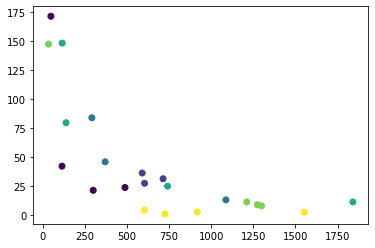

In [ ]:
plt.scatter(data["БП"],data['Отношение'], c=pd.Categorical(data["Тип"]).codes)
plt.show()

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


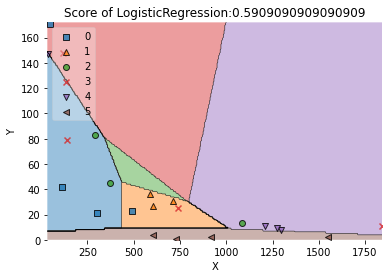

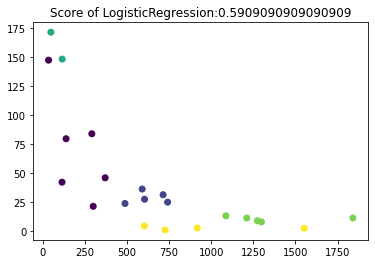

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


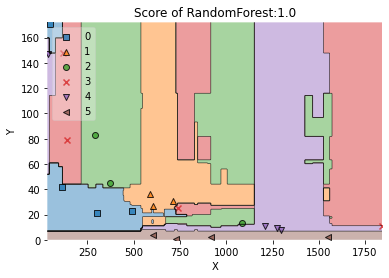

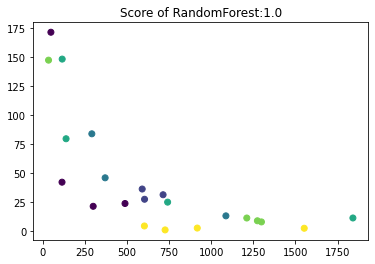

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


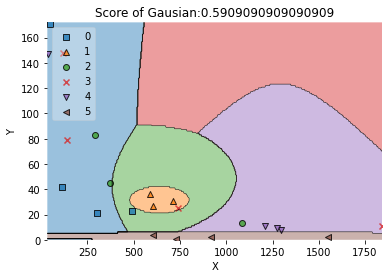

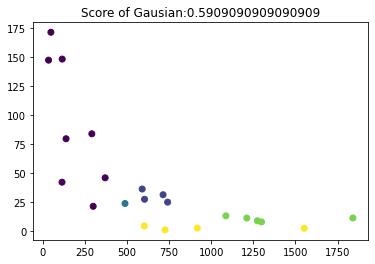

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


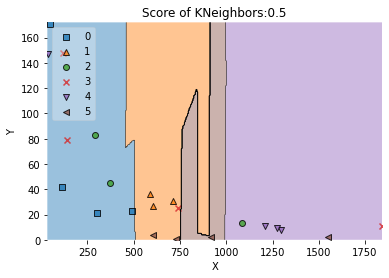

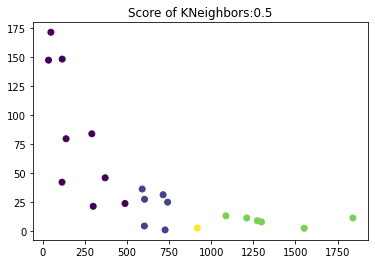

In [ ]:
for i, clf in algs.items():
    knn_comparison(data[["БП", "Отношение"]], data["Тип"],i, clf)
    knn_comparison2(data[["БП", "Отношение"]], data["Тип"],i, clf)    

# Отношение площади прямоугольника к бп

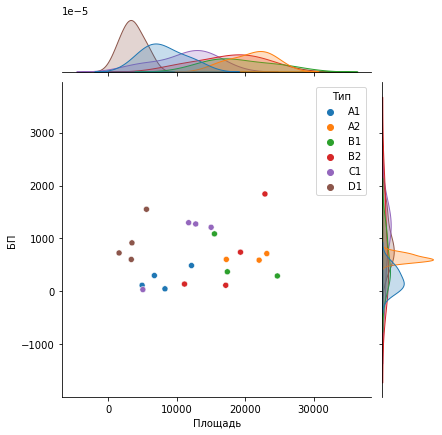

In [ ]:
sns.jointplot(data=data, x="Площадь", y="БП", hue="Тип")

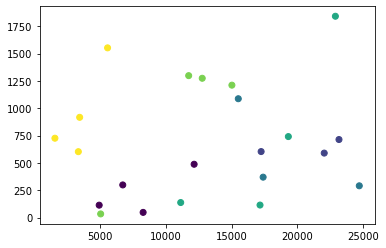

In [ ]:
plt.scatter(data["Площадь"],data['БП'], c=pd.Categorical(data["Тип"]).codes)
plt.show()

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


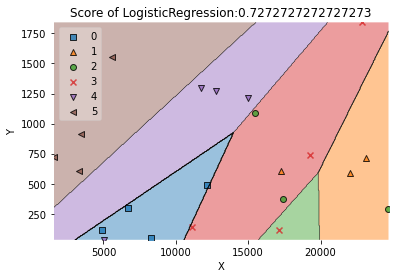

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


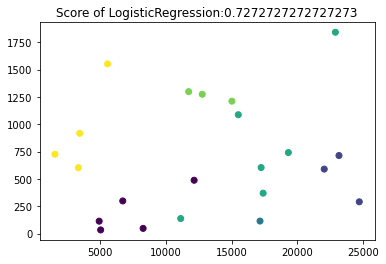

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


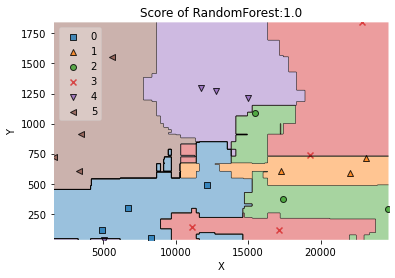

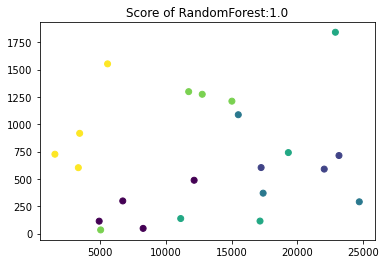

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


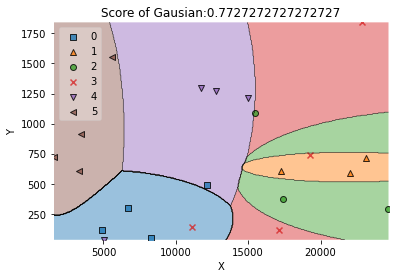

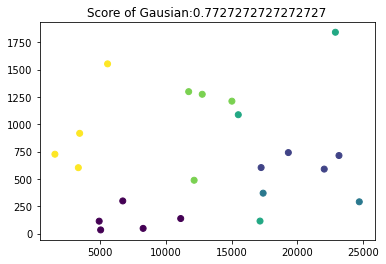

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


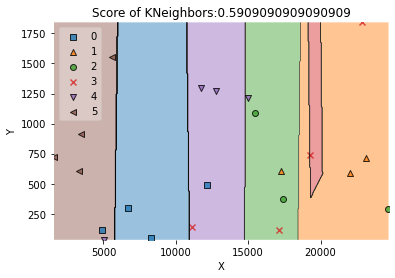

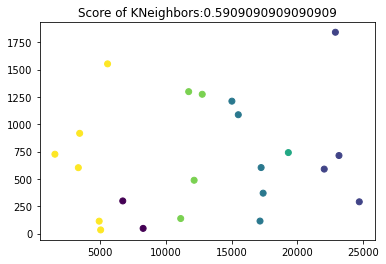

In [ ]:
for i, clf in algs.items():
    knn_comparison(data[["Площадь","БП"]], data["Тип"],i, clf)
    knn_comparison2(data[["Площадь","БП"]], data["Тип"],i, clf)    

# Отношение ЧП к БП

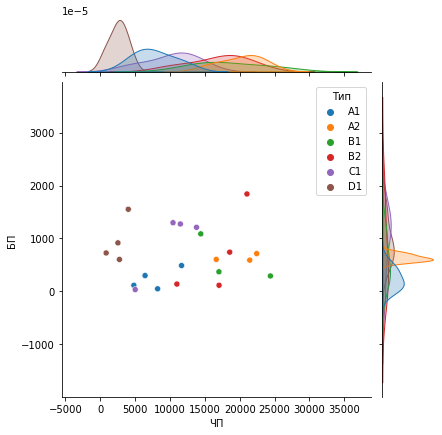

In [ ]:
sns.jointplot(data=data, x="ЧП", y="БП", hue="Тип")

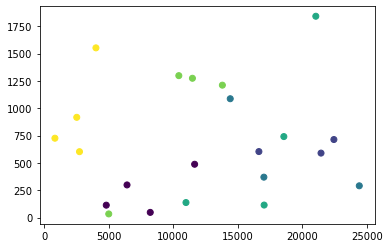

In [ ]:
plt.scatter(data["ЧП"],data['БП'], c=pd.Categorical(data["Тип"]).codes)
plt.show()

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


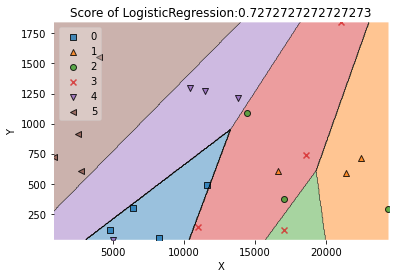

/home/danil/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


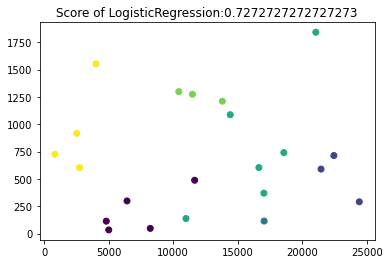

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


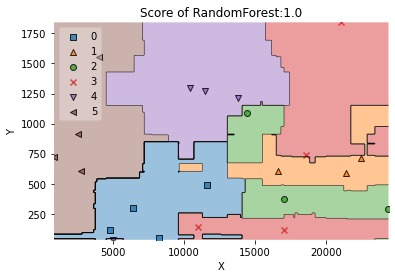

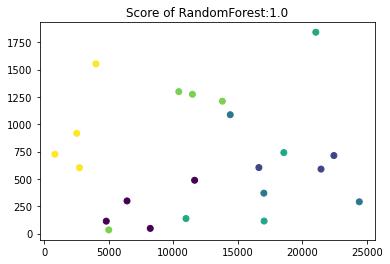

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


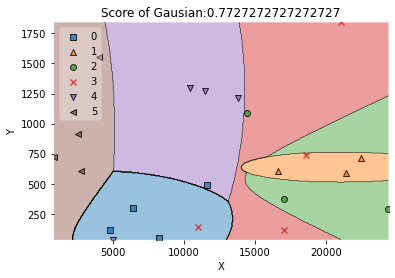

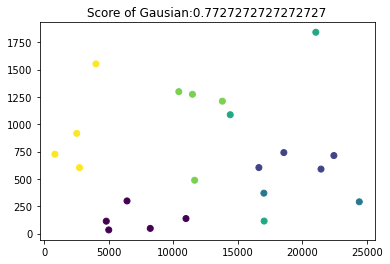

/home/danil/anaconda3/lib/python3.9/site-packages/mlxtend/plotting/decision_regions.py:274: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x=x_data,


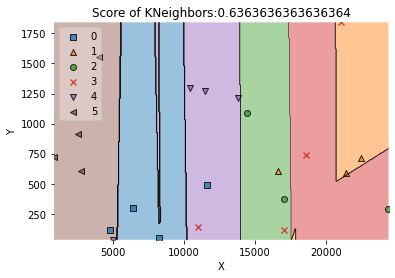

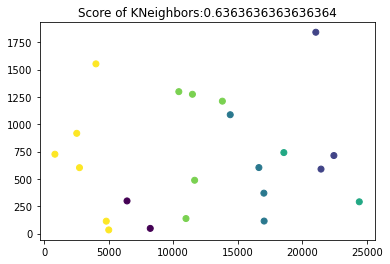

In [ ]:
for i, clf in algs.items():
    knn_comparison(data[["ЧП","БП"]], data["Тип"],i, clf)
    knn_comparison2(data[["ЧП","БП"]], data["Тип"],i, clf)    

# Отношение ЧП к Площади МВО

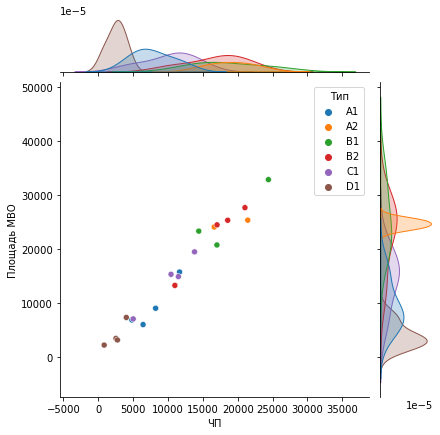

In [143]:
sns.jointplot(data=data, x="ЧП", y="Площадь МВО", hue="Тип")

# Отношение БП к Площади МВО

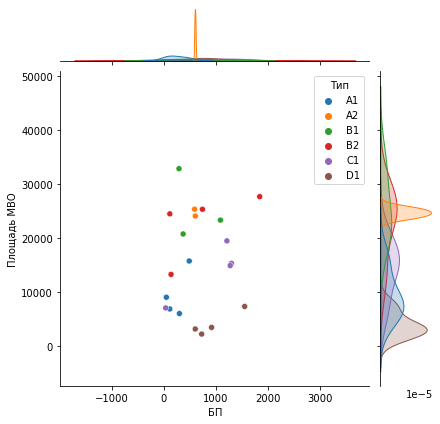

In [144]:
sns.jointplot(data=data, x="БП", y="Площадь МВО", hue="Тип")

# Отношение Площади прямоугольника к Площади МВО

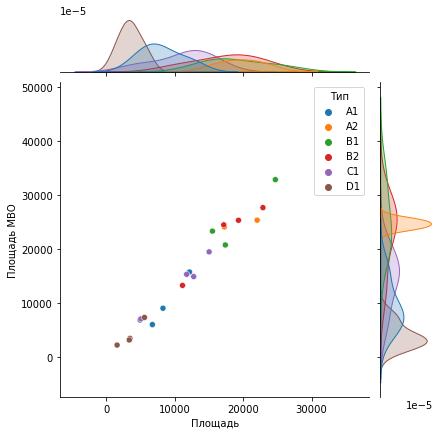

In [145]:
sns.jointplot(data=data, x="Площадь", y="Площадь МВО", hue="Тип")

# Отношение Фрактальной размерности к Плоащади МВО

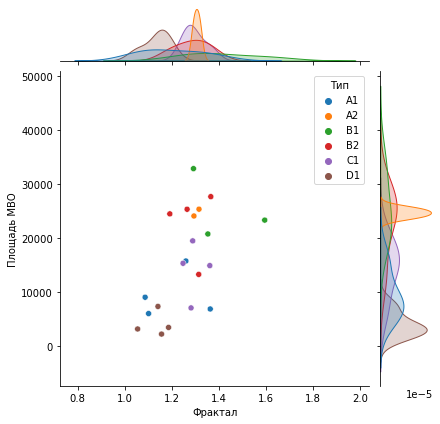

In [146]:
sns.jointplot(data=data, x="Фрактал", y="Площадь МВО", hue="Тип")

# Отношение Отношения ЧП к БП к Площади МВО

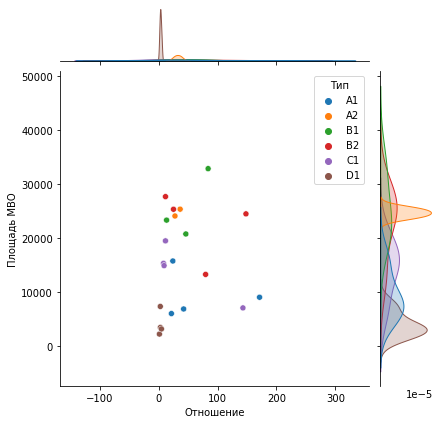

In [148]:
sns.jointplot(data=data, x="Отношение", y="Площадь МВО", hue="Тип")